In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import tiktoken
enc = tiktoken.get_encoding("gpt2")

import re

cuda


build a gpt model from scratch using transfoer architecture

sincos position ambedding

multi head attetnion with flash attetnion and autoregressive behaviour

decoder only transfoer

swiglu activation function

rmsnorm

learning_rate_sheduler

mixed precision (bfloat16)

MoE

logging teh metrics like loss etc

preplixity or bert score for evaluation



In [ ]:
from dataclasses import dataclass
@dataclass
class GPTParameters:
  d_model:int = 512 # embedding dimension
  block_size:int = 256 # context length
  batch_size:int = 16  # batch_size
  vocab_size:int = enc.n_vocab  # vocab size of tiktoken
  n_heads:int = 8  # 512/8 = 64
  n_layers:int = 10
  max_len:int = 256   # must match block_size
  dropout:float = 0.2


with open("combine.txt" ,"r") as f:
  data = f.read()

tokens = enc.encode(data)
print("Total no of Tokens :",len(tokens))

Total no of Tokens : 2790391


# Custom dataloader class(Faster)

In [ ]:
tokens = enc.encode(data)  # encode the dataset  ==> It is 1D we need to conver it to 2D
tokens_tensor = torch.tensor(tokens,dtype=torch.long) # convert the tokens to tensor

n = int(0.9 * len(tokens_tensor))
train = tokens_tensor[:n]  # first 90% for training
val = tokens_tensor[n:]  # reaming 10% for validation


class DataLoaderLite:
  def __init__(self,config,data):
    self.data = data
    self.block_size = config.block_size
    self.batch_size = config.batch_size

  def get_batch(self):
    """
    Random Sampling:
    For every training step, we randomly pick starting positions from the data.
    Suppose our data has 10,000 tokens and we want 4 sequences per batch
      len(self.data) = 10000
		  block_size = 256
			batch_size = 4
      output of torch.randint ==> tensor([876, 4921, 7321, 193])
    """
    # Step 1: Random Sampling
    ix = torch.randint(len(self.data) - self.block_size,(self.batch_size,))

    # Step 2: x(input)
    x = torch.stack([self.data[i:i+self.block_size] for i in ix]) # [1,2,3,4,5,6]

    # Step 3: y(target)
    y = torch.stack([self.data[i+1:i+1+self.block_size] for i in ix]) # [2,3,4,5,6,7]

    if device == "cuda":
      x = x.pin_memory()
      y = y.pin_memory()

    return x.to(device,non_blocking=True),y.to(device,non_blocking=True)


config = GPTParameters()
train_data =  DataLoaderLite(data=train,
                             config = config)
val_data = DataLoaderLite(data=val,
                          config=config)

torch.set_float32_matmul_precision("high")

train_data.get_batch()


(tensor([[  366, 18639,   286,  ...,   421, 25678,   287],
         [  352,   301, 23490,  ...,  1719,  2761,   764],
         [  262,  1109,   673,  ...,   583, 31551,   286],
         ...,
         [21337,   286,  4523,  ...,   257,  2119,  2488],
         [ 2448, 18840,   705,  ..., 14384, 16519,   422],
         [  407,  2206,   262,  ...,    83,   666, 20942]], device='cuda:0'),
 tensor([[18639,   286,   262,  ..., 25678,   287,   262],
         [  301, 23490,   837,  ...,  2761,   764,  5845],
         [ 1109,   673,  3011,  ..., 31551,   286,   262],
         ...,
         [  286,  4523, 23171,  ...,  2119,  2488,    12],
         [18840,   705,    82,  ..., 16519,   422,  2448],
         [ 2206,   262,  6625,  ...,   666, 20942,   373]], device='cuda:0'))

# Pytorch DataLoader class

In [ ]:

tokens = enc.encode(data)  # encode the dataset  ==> It is 1D we need to conver it to 2D
tokens_tensor = torch.tensor(tokens,dtype=torch.long) # convert the tokens to tensor

n = int(0.9 * len(tokens_tensor))
train = tokens_tensor[:n]  # first 90% for training
val = tokens_tensor[n:]  # reaming 10% for validation


class GPTDataClass(Dataset):

  def __init__(self,config,tokens):
    self.tokens = tokens
    self.block_size = config.block_size

  def __len__(self):
    return len(self.tokens) - self.block_size

  def __getitem__(self,idx):
    x = self.tokens[idx:idx+self.block_size]
    y = self.tokens[idx+1:idx+1+self.block_size]
    return x,y

config = GPTParameters()
train_dataset = GPTDataClass(config,train)
val_dataset = GPTDataClass(config,val)

train_loader = DataLoader(train_dataset,
                          pin_memory=True,
                          num_workers=2,
                          shuffle=True,
                          batch_size=config.batch_size)


val_loader = DataLoader(val_dataset,
              pin_memory=True,
              shuffle=False,
              batch_size = config.batch_size)


for x,y in train_loader:
  print(x)
  print("="*100)
  print(y)
  break


# default is highest(float32) ==> high(tensorfloat32)
# "highest"  ==> FP32   # Full precision(fp32) (slowest, most accurate)
# "high"     ==> TF32   # TensorFloat32 (fast, slightly less accurate)
# "medium"   ==> FP16 / BF16 mixed  # Fastest, lowest precision
torch.set_float32_matmul_precision("high")

print("TF32 enabled:", torch.backends.cuda.matmul.allow_tf32)
print("BF16 supported:", torch.cuda.is_bf16_supported())
print("FP16 supported:", torch.cuda.is_available())

tensor([[10890,    11,   763,    12, 20123,   425,  1429,  1022],
        [ 5386, 15387,   290, 11257,    13,   257,    72,    12],
        [   13,    17,   220,   220,   220,   220,   220,   220],
        [28127,   803,   290, 20796, 32660,    76,  7351, 31108]])
tensor([[   11,   763,    12, 20123,   425,  1429,  1022,  1692],
        [15387,   290, 11257,    13,   257,    72,    12, 15808],
        [   17,   220,   220,   220,   220,   220,   220,   220],
        [  803,   290, 20796, 32660,    76,  7351, 31108,    13]])
TF32 enabled: True
BF16 supported: False
FP16 supported: False


In [ ]:
import math
# Multi Head Attetnion

 #============================================================== MultiHeadAttention ==================================================

class MultiHeadAttetnion(nn.Module):
  def __init__(self,config):
    super().__init__()
    assert config.d_model % config.n_heads == 0,"Head is not divisible by embedding dimesnion chose differnt head value"
    self.att = nn.Linear(config.d_model,3*config.d_model) # linear layer to generate Q,K and V
    self.att_proj = nn.Linear(config.d_model,config.d_model) # projection layer for Q,K and V
    self.n_heads = config.n_heads
    self.d_model = config.d_model
    self.d_heads = config.d_model // config.n_heads
    # this create masked once during initlization more effiecnet compare to creating maske on every forward pass
    self.register_buffer("bias",torch.tril(torch.ones(config.block_size,config.block_size)).view(1,1,config.block_size,config.block_size)) #(B,n_head,T,T)

  def forward(self,x,flash_attention=False):
    B,T,C = x.shape #(B,T,C)  input

    qkv = self.att(x) # Generate Q,K and V vector ==>(B,T,3*C)
    # torch.Tensor.split(split_size, dim)
    q,k,v = qkv.split(self.d_model,dim=2)

    q = q.view(B,T,self.n_heads,self.d_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)
    k = k.view(B,T,self.n_heads,self.d_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)
    v = v.view(B,T,self.n_heads,self.d_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)

    # FLASH ATTENTION
    if flash_attention:
      y = torch.nn.functional.scaled_dot_product_attention(q,k,v,
                                attn_mask=None, # for padding (encoder)
                                dropout_p = 0.1,
                                is_causal=True # for masking(autoregressive)
                              ) # ==> (B, n_head, T, d_head)     ==>flash attention compute attetnion in fused cuda kernel so we can not view attetnion plots
    else:
      # attetnion score
      att = q @ k.transpose(-2,-1) * (1.0/math.sqrt(k.size(-1)))

      # maks attention ==> token attetnd to only previous token and not the future tokens
      att = att.mask_fill(self.bias[:,:,:T,:T]==0, float("-inf")) # (B,n_head,T,T)

      att = F.softmax(att,dim=-1) # apply softmax on last dimension(C)

      # attetnion weight
      y = att @ v # (B,n_head,T,T) x (B,n_head,T,d_head) ===> (B,n_head,T,d_head)


    # Re assemble all head output side by side
    # C = n_head * d_head
    y = y.transpose(1,2).contiguous().view(B,T,C)

    # Output projection
    y = self.att_proj(y)

    return y

# ============================================================== Positional ENcoding ===================================================================

class PositionalEncoding(nn.Module):
  """
  Formulas:
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
  where:
    - pos is the position in the sequence
    - i is the dimension index
    - d_model is the embedding dimension
  """
  def __init__(self,config):
    """
    Args:
      max_len (int): maximum sequence length
      d_model (int): embedding dimension
    """
    super().__init__()

    # step 1 : # Create positional encoding matrix
    pe = torch.zeros(config.max_len,config.d_model)
    position = torch.arange(0,config.max_len,dtype=torch.float).unsqueeze(1) # ==> (max_len,d_model)

    # step 2: Calculate the division term: 10000^(2i/d_model)
    div_term = torch.exp(torch.arange(0,config.d_model,2).float() * -(math.log(10000.0/config.d_model)))

    # step 3: Apply sin to even indices cos to odd indices
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)

    # Add batch dimension: (max_len, d_model) ==> (1, max_len, d_model)
    pe = pe.unsqueeze(0)

    # register buffer so its not a parameter
    self.register_buffer("pe",pe)

  def forward(self,x):
    B,T,C = x.shape
    x = x + self.pe[:,:T,:]
    return x

# ====================================================================== RMSNorm ================================================

class RMSNorm(nn.Module):
  def __init__(self,config,eps=1e-8):
    super().__init__()
    self.eps = eps
    self.weights = nn.Parameter(torch.ones(config.d_model)) # # each feature dimension gets a learnable scaling factor.

  def forward(self,x):
    x = x.float()  # to calculate mean x has to be floating point no
    rms = torch.sqrt(x.pow(2).mean(dim=-1,keepdim=True) + self.eps)
    return (x/rms) * self.weights


# ======================================================= SwiGLU Activation Function ================================================

class SwiGLU(nn.Module):
  """

	  x ──► W1 ─────────────|
							element-wise multiply ──► W3 ──► output
	  x ──► W2 ──► Swish ──┘

  """
  def __init__(self,config):
    super().__init__()
    inner = config.d_model * 4
    self.w1 = nn.Linear(config.d_model,inner,bias=False)  # main path
    self.w2 = nn.Linear(config.d_model,inner,bias=False)  # gate path with swish activation function
    self.w3 = nn.Linear(inner,config.d_model,bias=False)  # projection layer
    self.act = nn.SiLU()
    self.dropout = nn.Dropout(config.dropout)

  def forward(self,x):
    a = self.w1(x)  # main path
    b  = self.act(self.w2(x))  # gate path with activation swish activation function
    y = a * b  # elemnet wise multiplication
    out = self.w3(y) # projection layer
    return self.dropout(out)


# ========================================================== FFNN ================================================

class FFNN(nn.Module):
  def __init__(self,config):
    """
    SwiGLU is a complete replacement for the standard Linear→ReLU→Linear pattern.
    """
    super().__init__()
    self.network = nn.Sequential(
        SwiGLU(config),  # non-linearity
        nn.Dropout(config.dropout)
    )

  def forward(self,x):
    x = self.network(x)
    return x

# ============================================================ Decoder Internall Block ==================================================

class Block(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.ln1 = RMSNorm(config) # pre-layer norm - 1 for attetnion block
    self.att = MultiHeadAttetnion(config) # multi head attetnion block
    self.ln2 = RMSNorm(config) # pre-layer norm - 2 for FFNN block
    self.ffn = FFNN(config)

  def forward(self,x):
    x = x + self.att(self.ln1(x),flash_attention=True)
    x = x + self.ffn(self.ln2(x))
    return x



# =============================================== GPTModle ==============================================

class MyGPTModel(nn.Module):
  def __init__(self,config):
    super().__init__()

    self.transformer = nn.ModuleDict({
        "wte":nn.Embedding(config.vocab_size,config.d_model),
        "pe":PositionalEncoding(config),
        "h":nn.ModuleList(Block(config) for _ in range(config.n_layers)),
        "ln_f":RMSNorm(config)
    })

    # linear layer after trasnfoer block
    self.lm_head = nn.Linear(config.d_model,config.vocab_size,bias=False)

    # In GPT the same weight matrix is used for both word embedding and final output layer.
    # Weight tying (share token embedding weights with output head)  save computatuion heavily
    self.lm_head.weight = self.transformer["wte"].weight


  def forward(self,x,target=None):
    B,T = x.shape  # input doesnot have C dimension as it is not yet converted to Embeddings

    # step 1: token embedding + pos embedding
    tok_emb = self.transformer["wte"](x)
    pos_emb = self.transformer["pe"](tok_emb)  # it internally add ==> tok_emb + pos_emb


    # step 2: Multi Head attention
    for block in self.transformer.h:
      x = block(pos_emb)

    x = self.transformer["ln_f"](x)


    # Get logits after final transformer layer
    logits = self.lm_head(x)  # (B,T,vocab_size)


    loss = None
    if target is not None:
      B,T,C = logits.shape  #(B,T,C)  cross entorpy ==> accept (B,C)
      logits = logits.view(B*T,C)
      target = target.view(B*T)
      loss = F.cross_entropy(logits,target)
    return logits,loss

model = MyGPTModel(config).to(device)
model = torch.compile(model)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9,0.95),eps=1e-8,weight_decay=0.1)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Total Trainable Parameters: 67,705,856


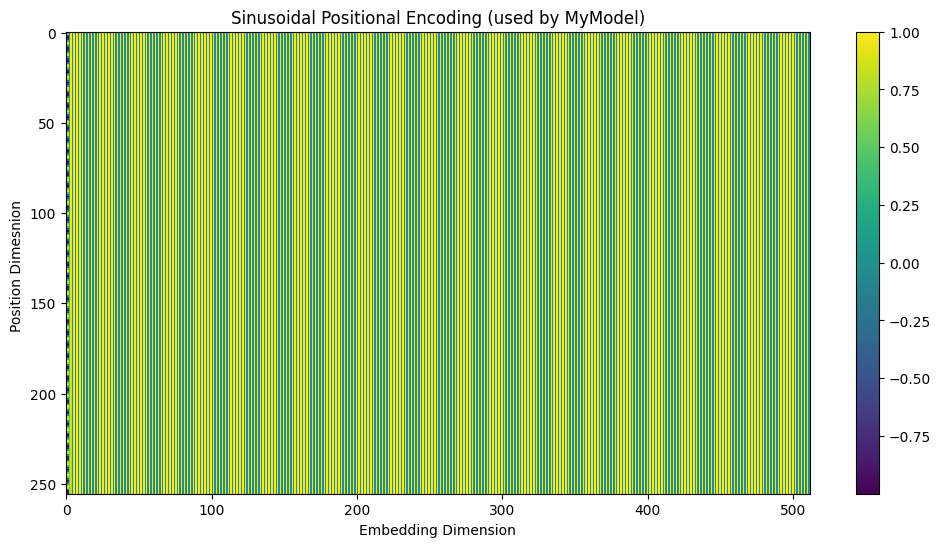

In [ ]:
pe = model.transformer["pe"].pe.squeeze(0).detach().cpu()

plt.figure(figsize=(12, 6))
plt.imshow(pe,cmap="viridis",aspect="auto",interpolation="nearest")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position Dimesnion ")
plt.title("Sinusoidal Positional Encoding (used by MyModel)")
plt.colorbar()
plt.show()

# Custom Training Loop

In [ ]:
import logging
from tqdm import tqdm


eval_interval = 1000
save_interval = eval_interval    # save checkpoint every n stpes


# ===================== Learning rate schedule ======================
max_lr = 6e-4
min_lr = max_lr * 0.1 # 10% of max lr
warmup_steps = 10
max_steps = 3000
def get_lr(t):
  """
  t:current step
  The learning rate will increase linearly and when it reaches warmup step it start to decrease using cosine decay
  """
  # 1) linear warmup(when current step is less than warmpu step we increase learning rate)
  if t < warmup_steps:
    return max_lr * (t+1)/warmup_steps

  # 2) Cosine Decay  ==> when it reaches warmup steps
  decay_steps = max_steps - warmup_steps
  progress = (t- warmup_steps) / decay_steps
  cosine_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * progress))
  return cosine_lr


  # ================================== Eval Loss Calculation ==========================

@torch.no_grad()
def loss_calculation(eval_interval):
  model.eval()
  val_losses = []
  for _ in range(eval_interval):
    xb,yb = val_data.get_batch()
    logits,loss = model(xb,yb)
    val_losses.append(loss.item())
  return sum(val_losses) / len(val_losses)

# ============================== Logging =========================

# =================================== Checkpoint Helper ==============================

def save_checkpoint(step, avg_train_loss, avg_val_loss, filename):
    """Save model checkpoint with training state"""
    checkpoint = {
        "step": step,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),  # Save scaler state too
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": learning_rate[-1] if learning_rate else 0,
        "config": {
            "max_lr": max_lr,
            "min_lr": min_lr,
            "warmup_steps": warmup_steps,
            "max_steps": max_steps,
            "accum_steps": accum_steps
        }
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")




scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)

In [ ]:
import json
import logging
import time


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler("training_logs.txt", mode="a")
    ],
    force=True
)


learning_rate = []
train_loss = []
val_loss = []
cycle_times = []


max_steps = 2000
accum_steps = 4
num_batch_per_step = config.batch_size   # batch size

best_val_loss = float("inf")


# ========================================================= Training Loop =================================

print("Starting training...")
cycle_start_time = time.time()
for step in tqdm(range(max_steps),desc="training"):
  total_train_loss = 0
  model.train()

  for i in range(num_batch_per_step):
    # ================================= Forward + Backward Propogation ==================================================
    xb,yb = train_data.get_batch()
    if device == "cuda":
      with torch.cuda.amp.autocast():
        logits,loss = model(xb,yb)
    else:
        logits,loss = model(xb,yb)
    loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
    scaler.scale(loss).backward()


# ============================ Gradient Accumulation Updatate ===========================================
    if (i+1) % accum_steps == 0:
      # Unscale gradients before clipping
      scaler.unscale_(optimizer)

      # Gradinet clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

      # Learning rate scheduler
      lr = get_lr(step)
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      learning_rate.append(lr)

      # update parameters
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad(set_to_none=True)

    total_train_loss = total_train_loss + loss.item() * accum_steps
  avg_train_loss = total_train_loss / num_batch_per_step
  train_loss.append(avg_train_loss)



#========================================= Evaluation =========================================================
  # Evaluation
  if (step+1) % eval_interval ==0:
    # Calcaulating time taken per training cycle
    cycle_duration = time.time() - cycle_start_time
    cycle_times.append(cycle_duration)
    tqdm.write(f"Training cycle till step {step+1} took {cycle_duration/60:.2f} minutes")
    # reset cycle timer for next phase
    cycle_start_time = time.time()

    avg_val_loss = loss_calculation(eval_interval)
    val_loss.append(avg_val_loss)

    logging_msg = f"Step: {step+1}  |  train_loss: {avg_train_loss:.3f}  |  val_loss: {avg_val_loss:.3f}"
    logging.info(logging_msg)
    tqdm.write(logging_msg)


  # =============================== Save Best Model ===========================================

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), "best_model.pt")
      tqdm.write(f" New best model with loss: {best_val_loss:.2f}, model saved!")

  # =========================== CheckPointing =================
  if (step + 1) % save_interval == 0 or (step + 1) == max_steps:
    current_val_loss = val_loss[-1] if val_loss else None  # get val loss
    save_checkpoint(
        step = step + 1,
        avg_train_loss = avg_train_loss,
        avg_val_loss = current_val_loss,
        filename = f"checkpoint_step{step+1}.pt"
    )


   #======================== Save Final metrics ===============================
  metrics = {
       "train_loss":train_loss,
       "val_loss":val_loss,
       "learning_rate":learning_rate,
        "cycle_times":cycle_times,
       "config":{
           "max_steps":max_steps,
           "eval_interval":eval_interval,
           "warmup_step":warmup_steps,
           "max_lr":max_lr,
           "min_lr":min_lr
       }
   }
  with open("metrics.json","w") as f:
    json.dump(metrics,f,indent=2)

tqdm.write("\nTraining complete! Metrics saved to metrics.json")



Starting training...


training:  50%|████▉     | 999/2000 [59:56<59:23,  3.56s/it]

Training cycle till step 1000 took 59.94 minutes


training:  50%|████▉     | 999/2000 [1:01:12<59:23,  3.56s/it]

Step: 1000  |  train_loss: 9.124  |  val_loss: 9.824


training:  50%|████▉     | 999/2000 [1:01:12<59:23,  3.56s/it]

 New best model with loss: 9.82, model saved!


training:  50%|█████     | 1000/2000 [1:01:14<7:31:42, 27.10s/it]

Checkpoint saved: checkpoint_step1000.pt


training:  57%|█████▋    | 1141/2000 [1:09:36<52:24,  3.66s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Learning rate')

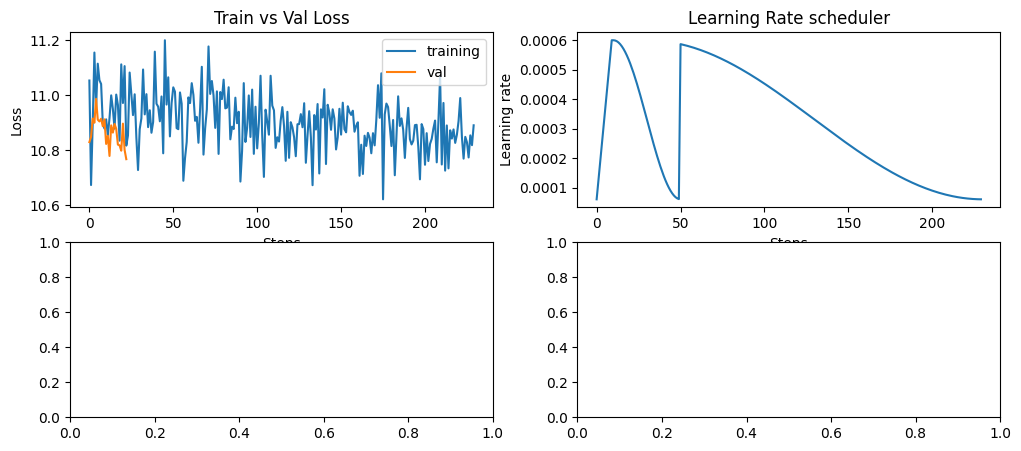

In [ ]:
with open("metrics.json","r") as f:
  metrics = json.load(f)

figure,axis = plt.subplots(nrows=2,ncols=2,figsize=(12,5))
axis = axis.flatten()

steps_train_loss = range(len(metrics["train_loss"]))
steps_val_loss = range(len(metrics["val_loss"]))

axis[0].plot(steps_train_loss,metrics["train_loss"],label="training")
axis[0].plot(steps_val_loss,metrics["val_loss"],label="val")
axis[0].set_title("Train vs Val Loss")
axis[0].set_xlabel("Steps")
axis[0].set_ylabel("Loss")
axis[0].legend()


axis[1].plot(metrics["learning_rate"])
axis[1].set_title("Learning Rate scheduler")
axis[1].set_xlabel("Steps")
axis[1].set_ylabel("Learning rate")

axis[2].plot(metrics["step_times"])
axis[2].set_title("Time taken per Training loop")
axis[2].set_xlabel("Training steps")
axis[2].set_ylabel("Time Taken ")


# Reload From Checkpoint

In [ ]:
import json
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler("training_logs.txt", mode="a")
    ],
    force=True
)
def load_checkpoint(filename):
    """Load checkpoint and resume training"""
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_step = checkpoint["step"]

    print(f"Resumed from step {start_step}")
    print(f"Checkpoint loaded: {filename}")
    print(f" Resuming from step {start_step}")
    print(f" Previous train loss: {checkpoint['train_loss']:.4f}")
    if checkpoint['val_loss'] is not None:
      print(f"Previous val loss: {checkpoint['val_loss']:.4f}")
    return start_step

# ============================= Load Metrics ======================================

def load_metrics(filename="metrics.json"):
  with open("metrics.json","r") as f:
    metrics = json.load(f)
  return metrics["train_loss"],metrics["val_loss"],metrics["learning_rate"],metrics["config"],metrics["cycle_times"]

# ================================== Hyperparameter ===================

max_steps = 10000
num_batch_per_step = 4   # batch size
accum_steps = 4


# ============================ Using above function=============================

# set a flag for stating from scratch or from where left off
resume_from_checkpoint = True # fasle to start from 0
checkpoint_file = "/content/checkpoint_step50.pt"

if resume_from_checkpoint:
  # load checkpoint
  start_step = load_checkpoint(checkpoint_file)

  # Load metrics
  train_loss,val_loss,learning_rate,config,step_times = load_metrics()
  eval_interval = config["eval_interval"]
  warmup_step = config["warmup_step"]
  max_lr = config["max_lr"]
  min_lr = config["min_lr"]
  best_val_loss = max(train_loss)


  cycle_start_time = time.time()
  # start training
  for step in tqdm(range(start_step,max_steps),desc="training"):
    start_time = time.time()
    total_train_loss = 0
    model.train()

    for i in range(num_batch_per_step):
      # ================================= Forward + Backward Propogation ==================================================
      xb,yb = train_data.get_batch()
      if device == "cuda":
        with torch.cuda.amp.autocast():
          logits,loss = model(xb,yb)
      else:
          logits,loss = model(xb,yb)
      loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
      scaler.scale(loss).backward()


  # ============================ Gradient Accumulation Updatate ===========================================
      if (i+1) % accum_steps == 0:
        # Unscale gradients before clipping
        scaler.unscale_(optimizer)

        # Gradinet clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

        # Learning rate scheduler
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
          param_group["lr"] = lr
        learning_rate.append(lr)

        # update parameters
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

      total_train_loss = total_train_loss + loss.item() * accum_steps
    avg_train_loss = total_train_loss / num_batch_per_step
    train_loss.append(avg_train_loss)

    # Time calculation
    step_duration = time.time() - start_time
    step_times.append(step_duration)
    tqdm.write(f"Step {step+1} took {step_duration:.3f} seconds")

  #========================================= Evaluation =========================================================
    # Evaluation
    if (step+1) % eval_interval ==0:
      # Calcaulating time taken per training cycle
      cycle_duration = time.time() - cycle_start_time
      cycle_times.append(cycle_duration)
      tqdm.write(f"Training cycle till step {step+1} took {cycle_duration/60:.2f} minutes")
      # reset cycle timer for next phase
      cycle_start_time = time.time()

      avg_val_loss = loss_calculation(eval_interval)
      val_loss.append(avg_val_loss)

      logging_msg = f"Step: {step+1}  |  train_loss: {avg_train_loss:.3f}  |  val_loss: {avg_val_loss:.3f}"
      tqdm.write(logging_msg)
      logging.info(logging_msg)

  # =============================== Save Best Model ===========================================

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), "best_model.pt")
      tqdm.write(f" New best model with loss: {best_val_loss:.2f}, model saved!")

    # =========================== CheckPointing =================
    if (step + 1) % save_interval == 0 or (step + 1) == max_steps:
      current_val_loss = val_loss[-1] if val_loss else None  # get val loss
      save_checkpoint(
          step = step + 1,
          avg_train_loss = avg_train_loss,
          avg_val_loss = current_val_loss,
          filename = f"checkpoint_step{step+1}.pt"
      )

    #======================== Save Final metrics ===============================
    metrics = {
        "train_loss":train_loss,
        "val_loss":val_loss,
        "learning_rate":learning_rate,
        "cycle_times":cycle_times,
        "config":{
            "max_steps":max_steps,
            "eval_interval":eval_interval,
            "warmup_step":warmup_step,
            "max_lr":max_lr,
            "min_lr":min_lr
        }
    }
    with open("metrics.json","w") as f:
      json.dump(metrics,f,indent=2)

  tqdm.write("\nTraining complete! Metrics saved to metrics.json")



Resumed from step 50
Checkpoint loaded: /content/checkpoint_step50.pt
 Resuming from step 50
 Previous train loss: 12.9416
Previous val loss: 13.1151


training:   2%|▎         | 4/160 [00:00<00:04, 34.11it/s]

 New best model with loss: 13.12, model saved!


training:   7%|▋         | 11/160 [00:00<00:09, 15.38it/s]

Step: 60  |  train_loss: 13.006  |  val_loss: 12.946
 New best model with loss: 12.95, model saved!
Checkpoint saved: checkpoint_step60.pt


training:  18%|█▊        | 28/160 [00:01<00:03, 33.97it/s]

Step: 70  |  train_loss: 13.457  |  val_loss: 12.819
 New best model with loss: 12.82, model saved!
Checkpoint saved: checkpoint_step70.pt



training:  18%|█▊        | 28/160 [00:01<00:03, 33.97it/s]

Step: 80  |  train_loss: 12.793  |  val_loss: 12.724
 New best model with loss: 12.72, model saved!
Checkpoint saved: checkpoint_step80.pt


training:  25%|██▌       | 40/160 [00:01<00:02, 43.71it/s]

Step: 90  |  train_loss: 12.915  |  val_loss: 12.545
 New best model with loss: 12.54, model saved!
Checkpoint saved: checkpoint_step90.pt


training:  30%|███       | 48/160 [00:01<00:02, 52.94it/s]

Step: 100  |  train_loss: 13.264  |  val_loss: 12.917
Checkpoint saved: checkpoint_step100.pt


training:  38%|███▊      | 60/160 [00:01<00:01, 52.71it/s]

Step: 110  |  train_loss: 12.778  |  val_loss: 12.677
Checkpoint saved: checkpoint_step110.pt


training:  42%|████▎     | 68/160 [00:01<00:01, 59.54it/s]

Step: 120  |  train_loss: 12.782  |  val_loss: 12.821
Checkpoint saved: checkpoint_step120.pt


training:  51%|█████▏    | 82/160 [00:02<00:01, 58.93it/s]

Step: 130  |  train_loss: 12.800  |  val_loss: 12.912
Checkpoint saved: checkpoint_step130.pt



training:  56%|█████▋    | 90/160 [00:02<00:01, 58.15it/s]

Step: 140  |  train_loss: 12.779  |  val_loss: 12.606
Checkpoint saved: checkpoint_step140.pt


training:  61%|██████▏   | 98/160 [00:02<00:00, 63.10it/s]

Step: 150  |  train_loss: 12.687  |  val_loss: 12.788
Checkpoint saved: checkpoint_step150.pt


training:  66%|██████▌   | 105/160 [00:02<00:00, 61.58it/s]

Step: 160  |  train_loss: 12.781  |  val_loss: 12.532
 New best model with loss: 12.53, model saved!
Checkpoint saved: checkpoint_step160.pt


training:  75%|███████▌  | 120/160 [00:02<00:00, 58.21it/s]

Step: 170  |  train_loss: 12.684  |  val_loss: 12.599
Checkpoint saved: checkpoint_step170.pt


training:  80%|████████  | 128/160 [00:02<00:00, 63.27it/s]

Step: 180  |  train_loss: 12.842  |  val_loss: 12.794
Checkpoint saved: checkpoint_step180.pt


training:  84%|████████▍ | 135/160 [00:02<00:00, 61.72it/s]

Step: 190  |  train_loss: 12.950  |  val_loss: 12.519
 New best model with loss: 12.52, model saved!
Checkpoint saved: checkpoint_step190.pt


training:  94%|█████████▍| 150/160 [00:03<00:00, 60.56it/s]

Step: 200  |  train_loss: 12.875  |  val_loss: 12.543
Checkpoint saved: checkpoint_step200.pt


training: 100%|██████████| 160/160 [00:03<00:00, 48.27it/s]

Step: 210  |  train_loss: 12.763  |  val_loss: 12.686
Checkpoint saved: checkpoint_step210.pt

Training complete! Metrics saved to metrics.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save file to drive
!mkdir -p /content/drive/MyDrive/GPT  #create a directery

!cp /content/checkpoint_step1000.pt /content/drive/MyDrive/GPT/
!cp metrics.json /content/drive/MyDrive/GPT/
!cp /content/training_logs.txt /content/drive/MyDrive/GPT/

Perplexity=e^CrossEntropyLoss

In [ ]:
import math
with open("metrics.json","r") as f:
  metrics = json.load(f)

val_losses = metrics["val_score"]
perplexities = [math.exp(loss) for loss in val_losses]
print("Perplexities:", perplexities)

plt.plot(perplexities, label="Validation Perplexity")
plt.xlabel("Evaluation Step")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


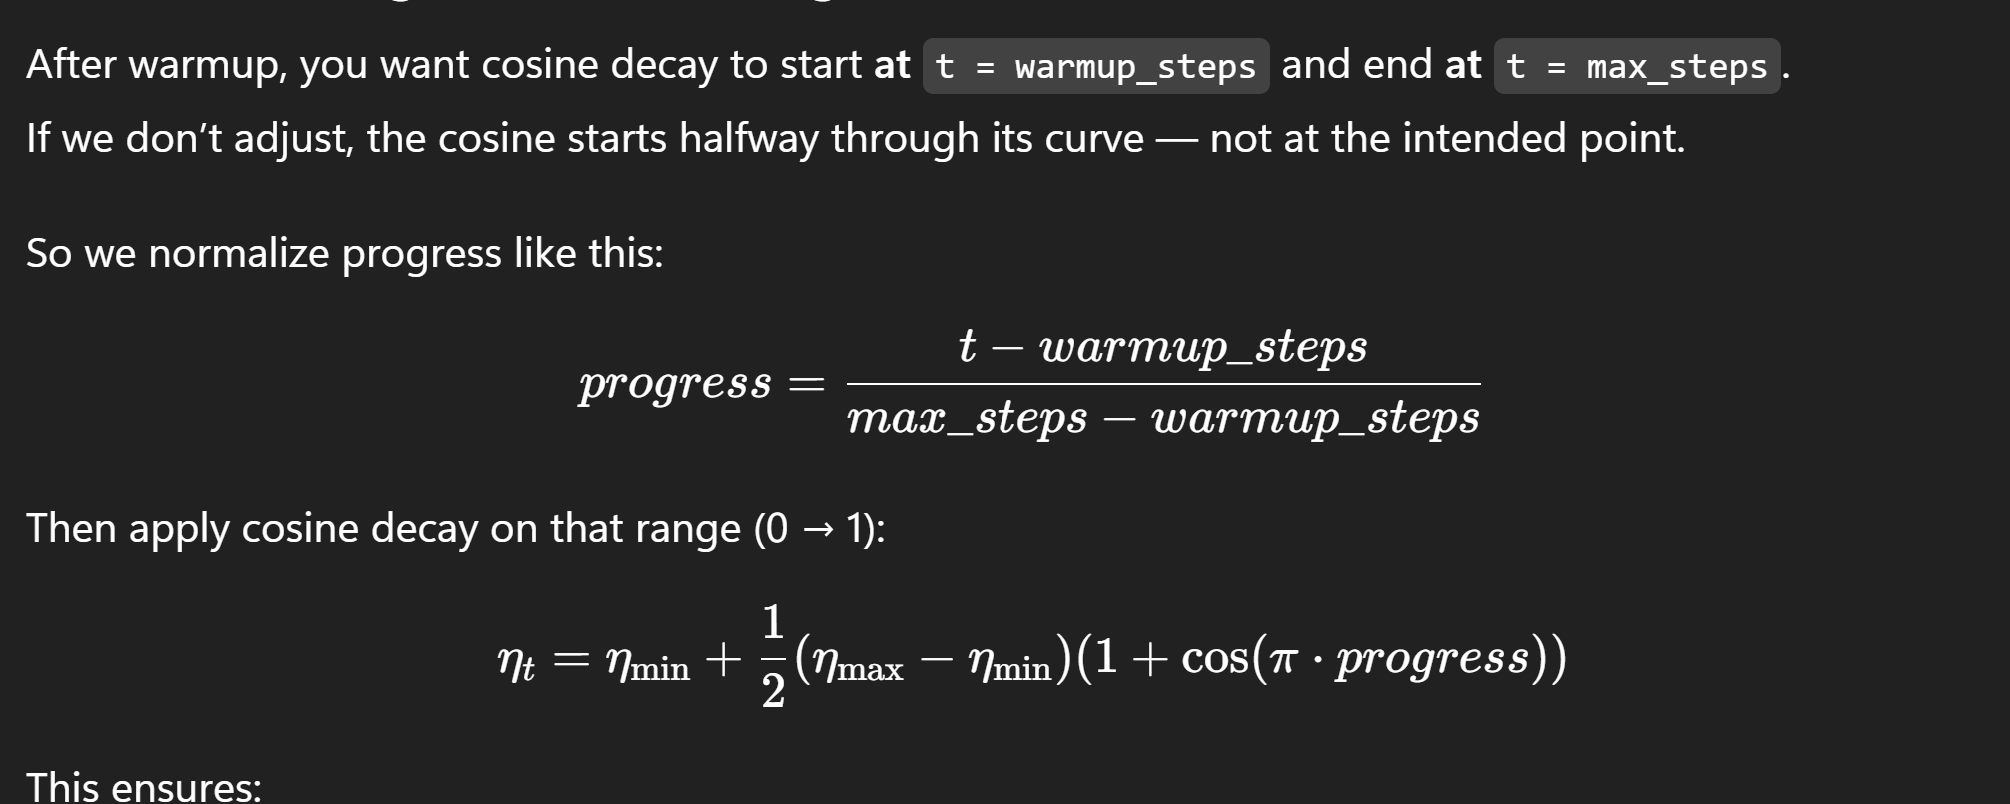

In [ ]:
# learning_rate = []
# train_loss = []
# val_loss = []

# scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)
# accum_steps = 50
# eval_interval = 10

# for step in range(max_steps):
#   total_train_loss = 0
#   model.train()

#   for batch_index,(xb,yb) in enumerate(train_loader):
#     # ================================= Forward + Backward Propogation ==================================================
#     if device == "cuda":
#       with torch.cuda.amp.autocast():
#         logits,loss = model(xb,yb)
#     else:
#         logits,loss = model(xb,yb)
#     loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
#     scaler.scale(loss).backward()


# # ============================ Gradient Accumulation Updatate ===========================================
#     if (batch_index+1) % accum_steps == 0:
#       # Unscale gradients before clipping
#       scaler.unscale_(optimizer)

#       # Gradinet clipping
#       torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

#       # Learning rate scheduler
#       lr = get_lr(step)
#       for param_group in optimizer.param_groups:
#         param_group["lr"] = lr
#       learning_rate.append(lr)

#       # update parameters
#       scaler.step(optimizer)
#       scaler.update()
#       optimizer.zero_grad(set_to_none=True)

#     total_train_loss = total_train_loss + loss.item() * accum_steps
#   avg_train_loss = total_train_loss / len(train_loader)
#   train_loss.append(avg_train_loss)



# #========================================= Evaluation =========================================================
#   # Evaluation
#   if (step+1) % eval_interval ==0:
#     avg_val_loss = loss_calculation(val_loader)
#     val_loss.append(avg_val_loss)

#     print(f"Step: {step+1}  |  train_loss: {avg_train_loss:.3f}  |  val_loss: {avg_val_loss:.3f}")